# $$\textbf{Computational Statistics}$$
## $$\textbf{TP4: Improve the Metropolis-Hastings algorithm}$$
$$ \textbf{Boubacar Sow, boubacar.sow@ens-paris-saclay.fr}
$$

# $\textbf{Imports}$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# **Exercice 1**
**Question1** <br>
Implement the MCMC algorithm with kernel P ans Hastings Metropolis filter

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mcmc_hasting_metropolis(
    start_state: np.ndarray, 
    p: float, 
    sigma: np.ndarray, 
    a: float, 
    num_iterations: int
) -> tuple:
    
    def target_distribution(state: np.ndarray, a: float) -> float:
        x, y = state
        return -((x/a)**2) - y**2 - (1/4)*(((x/a)**2 - y**2)**2)

    def update_state_component(current_state: np.ndarray, sigma: np.ndarray, component_index: int) -> np.ndarray:
        state_copy = current_state.copy()
        state_copy[component_index] = np.random.normal(state_copy[component_index], sigma[component_index])
        log_a = min(0, target_distribution(state_copy, a) - target_distribution(current_state, a))
        if np.log(np.random.rand()) <= log_a:
            return state_copy
        else:
            return current_state

    states = np.zeros((num_iterations, 2))
    states[0, :] = start_state
    acceptance_rate = [0, 0]
    acceptance_rate_history = []

    for i in range(1, num_iterations):
        current_state = states[i-1, :]
        for j in range(2):
            if np.random.uniform() <= p:
                proposed_state = update_state_component(current_state, sigma, j)
                if not np.array_equal(current_state, proposed_state):
                    current_state = proposed_state
                    acceptance_rate[j] += 1
        states[i, :] = current_state

        if i % 50 == 0:
            acceptance_rate_history.append([rate / 50 for rate in acceptance_rate])
            acceptance_rate = [0, 0]

    return states, np.array(acceptance_rate_history)


**Question 2**
Run the algorithm with $a = 10$ and standard deviations of the proposal distributions chosen as follows: $(\sigma_1, \sigma_2) = (3, 3)$. Plot (i) the trajectory of the Markov chain along the coordinates as well as (ii) the auto-correlation diagram on each coordinate (see pandas.DataFrame.corr).
Discuss the performance of the algorithm in this situation. Discuss the performance of the algorithm in this situation.

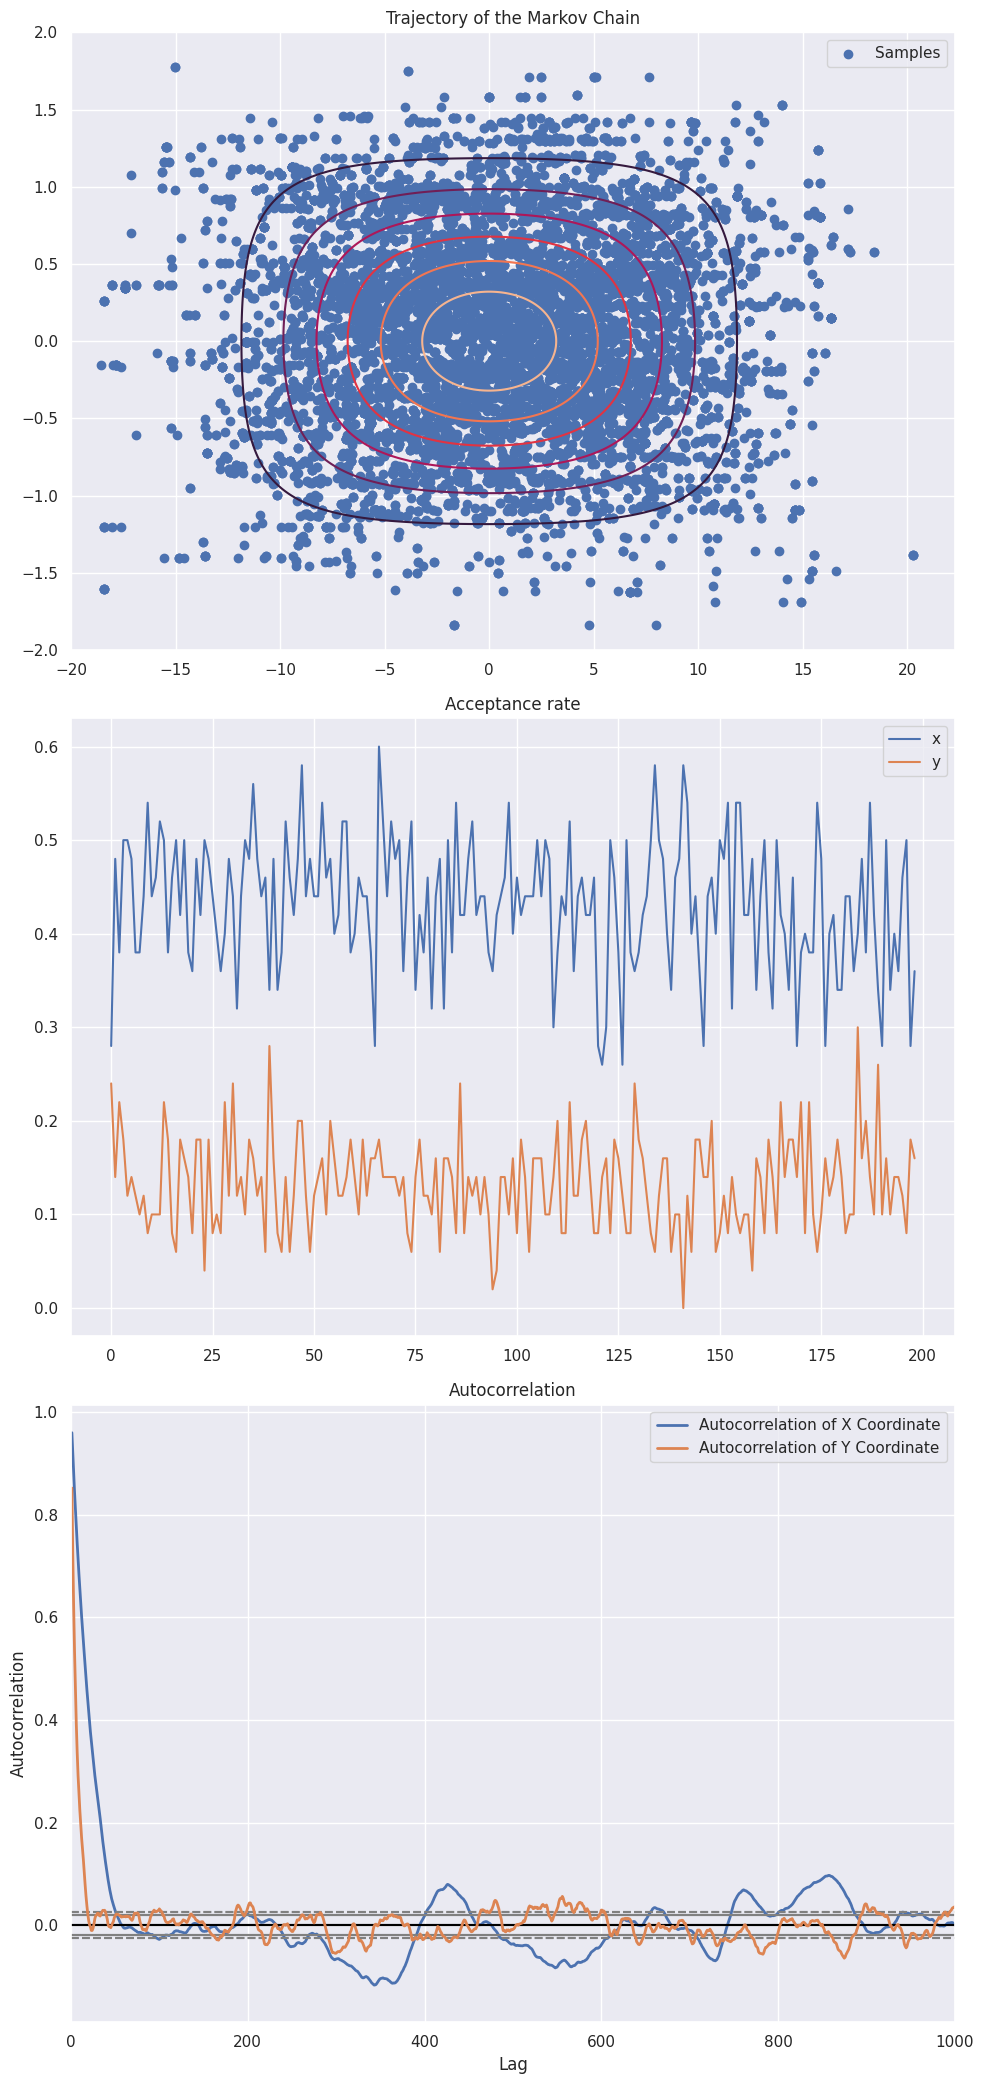

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_graphs(samples, acceptance_x, acceptance_y):
    x = np.linspace(-20, 20, 300)
    y = np.linspace(-2, 2, 300)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-((X/10)**2) - Y**2 - (1/4)*(((X/10)**2 - Y**2)**2))

    fig, axs = plt.subplots(3, figsize=(10, 21))

    axs[0].contour(X, Y, Z)
    axs[0].scatter(samples[:, 0], samples[:, 1], label='Samples')
    axs[0].set_title('Trajectory of the Markov Chain')
    axs[0].legend()

    axs[1].plot(acceptance_x, label='x')
    axs[1].plot(acceptance_y, label='y')
    axs[1].set_title('Acceptance rate')
    axs[1].legend()

    pd.plotting.autocorrelation_plot(samples[:, 0], ax=axs[2], label='Autocorrelation of X Coordinate', linewidth=2)
    pd.plotting.autocorrelation_plot(samples[:, 1], ax=axs[2], label='Autocorrelation of Y Coordinate', linewidth=2)
    axs[2].set_xlim((0, 1000))
    axs[2].set_title('Autocorrelation')

    plt.tight_layout()
    plt.show()

samples, acceptance_rate_history = mcmc_hasting_metropolis([1, 1], 0.5, [3, 3], 10, 10000)
acceptance_x, acceptance_y = np.transpose(acceptance_rate_history)
plot_graphs(samples, acceptance_x, acceptance_y)


**Comments**: We can conclude that the Markov chain is not exploring the state space efficiently in the x direction, we can also say that the proposed moves in the y direction are being rejected more than the one in the direction of x

**Question 3** <br>

**Improvements of the performance of the algorithm**


- Method 1: Adjusting the Variance
We can adjust the variance of the proposal distribution. This would control the dispersion of the samples and could modify the autocorrelation behavior.

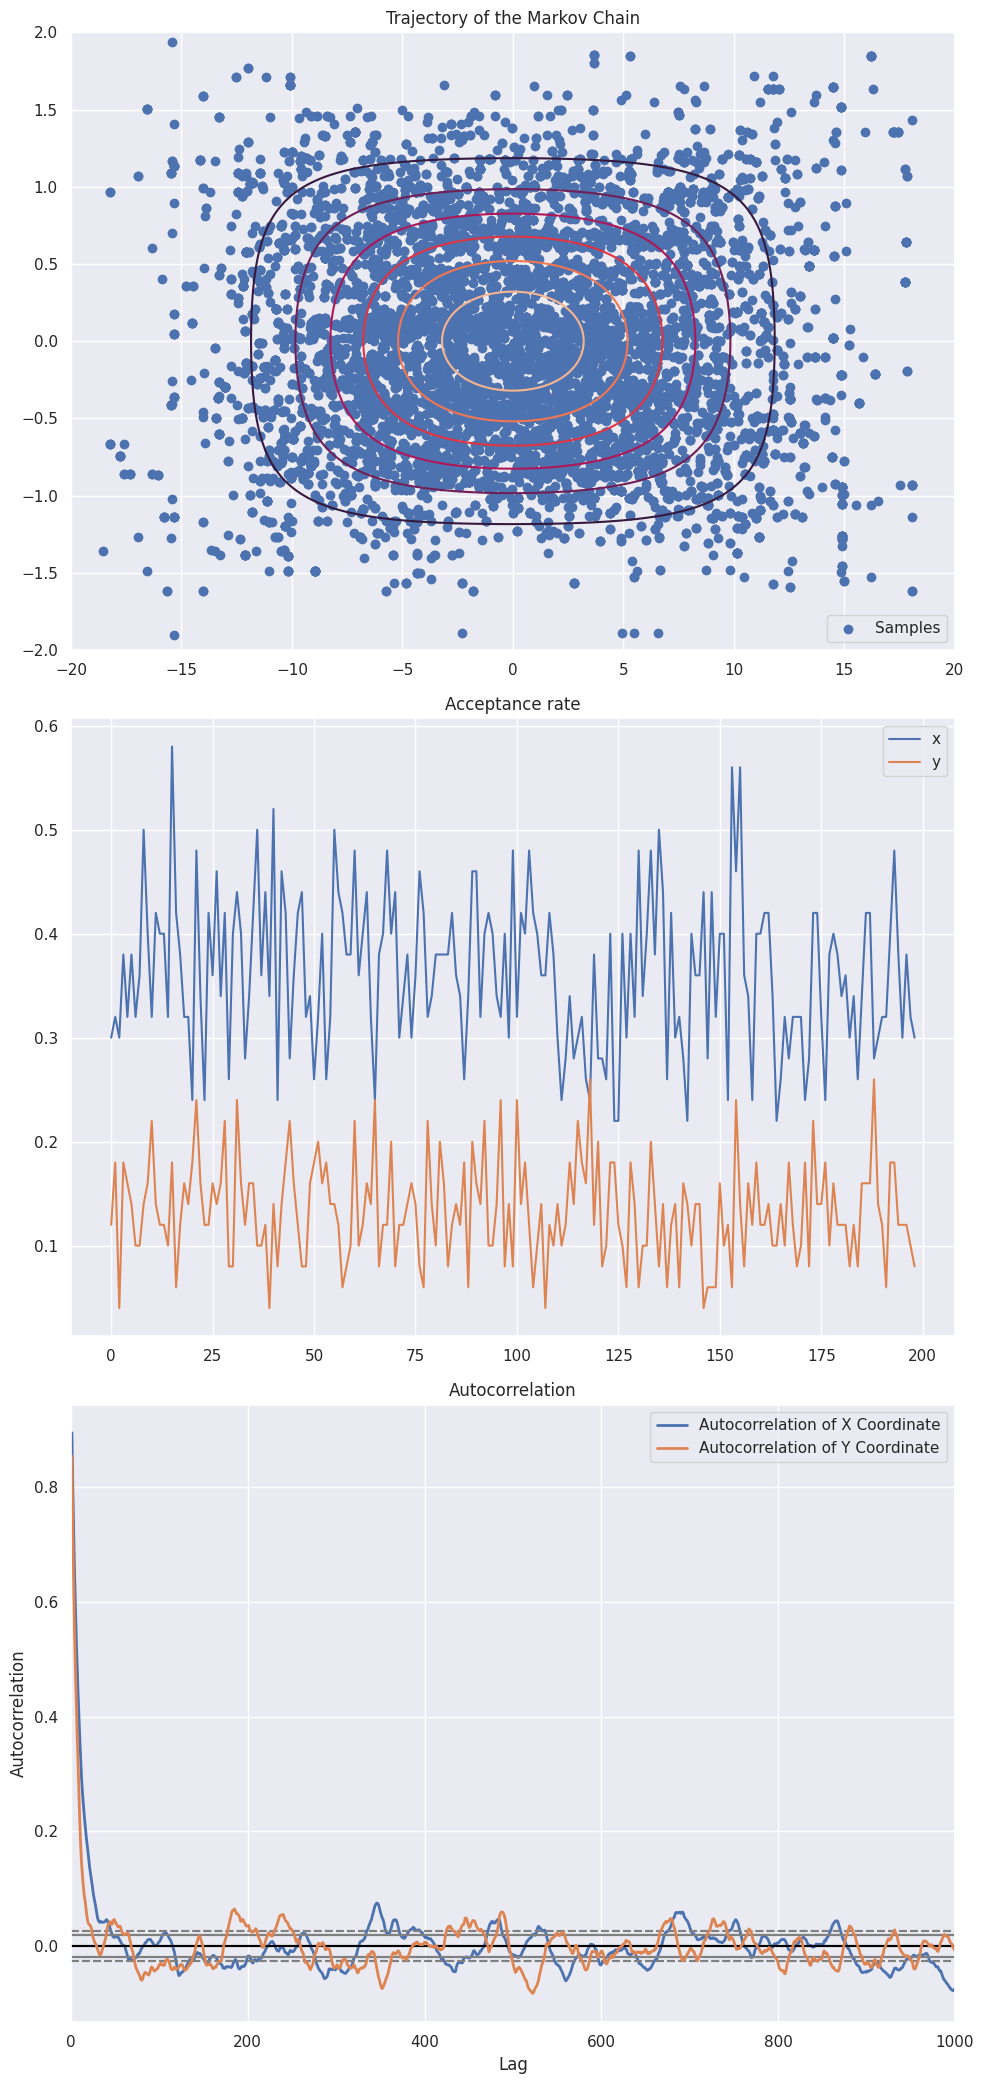

In [235]:
sigma = [6, 3]  # Increased variance for x, decreased for y

samples, acceptance_rate_history = mcmc_hasting_metropolis([1, 1], 0.5, sigma, 10, 10000)
acceptance_x, acceptance_y = np.transpose(acceptance_rate_history)
plot_graphs(samples, acceptance_x, acceptance_y)


- Method 2: Change the probability of accepting x


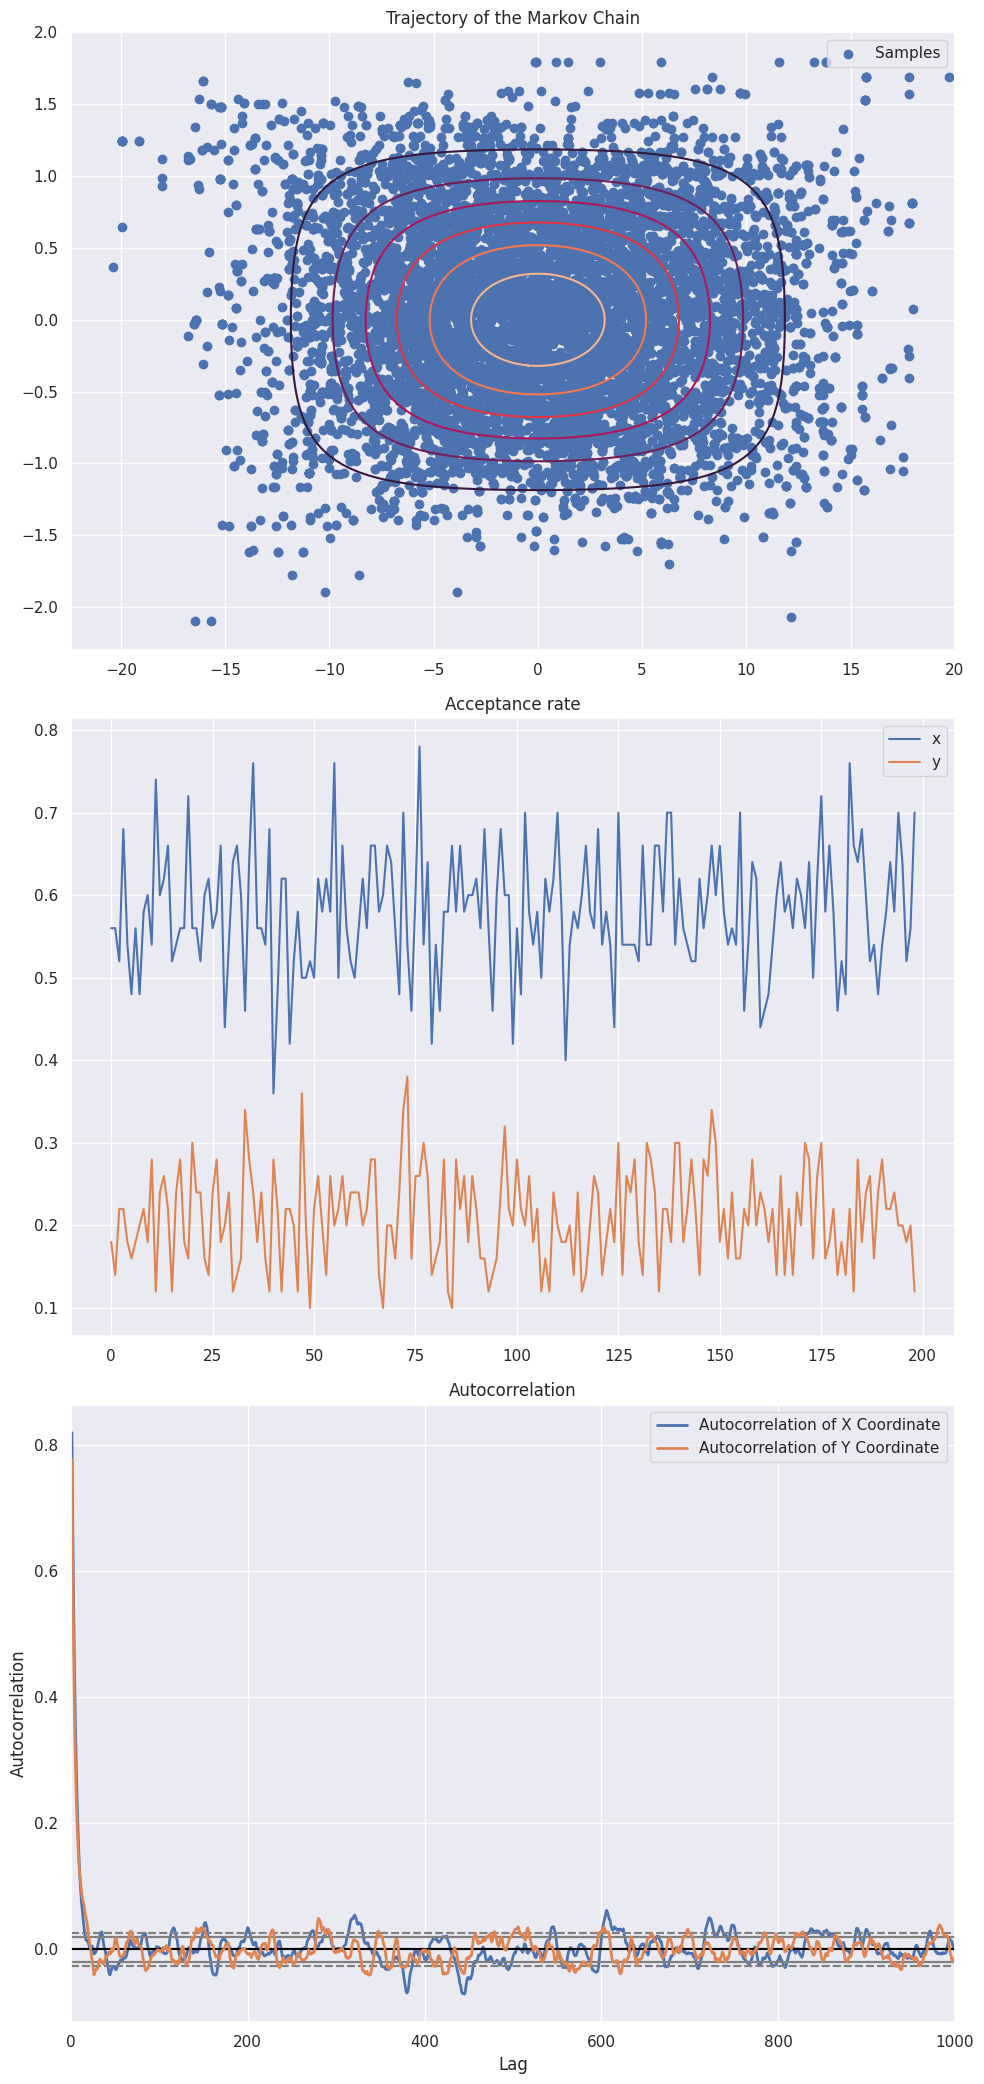

In [236]:
p = 0.8  # Increased probability of updating x
samples, acceptance_rate_history = mcmc_hasting_metropolis([1, 1], p, sigma, 10, 10000)
acceptance_x, acceptance_y = np.transpose(acceptance_rate_history)
plot_graphs(samples, acceptance_x, acceptance_y)

**Comments:** We can see on the two autocorrelation plots that the results have improved.

$\textbf{1.B Adaptive Metropolis-Hastings within Gbibs sampler}$

In [249]:
def adaptive_mcmc_hasting_metropolis(
    start_state: np.ndarray, 
    p: float, 
    sigma: np.ndarray, 
    a: float, 
    num_iterations: int
) -> tuple:
    
    def target_distribution(state: np.ndarray, a: float) -> float:
        x, y = state
        return -((x/a)**2) - y**2 - (1/4)*(((x/a)**2 - y**2)**2)

    def update_state_component(current_state: np.ndarray, sigma: np.ndarray, component_index: int) -> np.ndarray:
        state_copy = current_state.copy()
        state_copy[component_index] = np.random.normal(state_copy[component_index], sigma[component_index])
        log_a = min(0, target_distribution(state_copy, a) - target_distribution(current_state, a))
        if np.log(np.random.rand()) <= log_a:
            return state_copy
        else:
            return current_state

    states = np.zeros((num_iterations, 2))
    states[0, :] = start_state
    acceptance_rate = [0, 0]
    acceptance_rate_history = []
    log_sigma = np.log(sigma)

    for i in range(1, num_iterations):
        current_state = states[i-1, :]
        for j in range(2):
            if np.random.uniform() <= p:
                proposed_state = update_state_component(current_state, np.exp(log_sigma), j)
                if not np.array_equal(current_state, proposed_state):
                    current_state = proposed_state
                    acceptance_rate[j] += 1
        states[i, :] = current_state

        if i % 50 == 0:
            acceptance_rate_history.append([rate / 50 for rate in acceptance_rate])
            for j in range(2):
                if acceptance_rate[j] / 50 > 0.24:
                    log_sigma[j] += min(0.01, i**(-0.5))
                else:
                    log_sigma[j] -= min(0.01, i**(-0.5))
            acceptance_rate = [0, 0]

    return states, np.array(acceptance_rate_history)




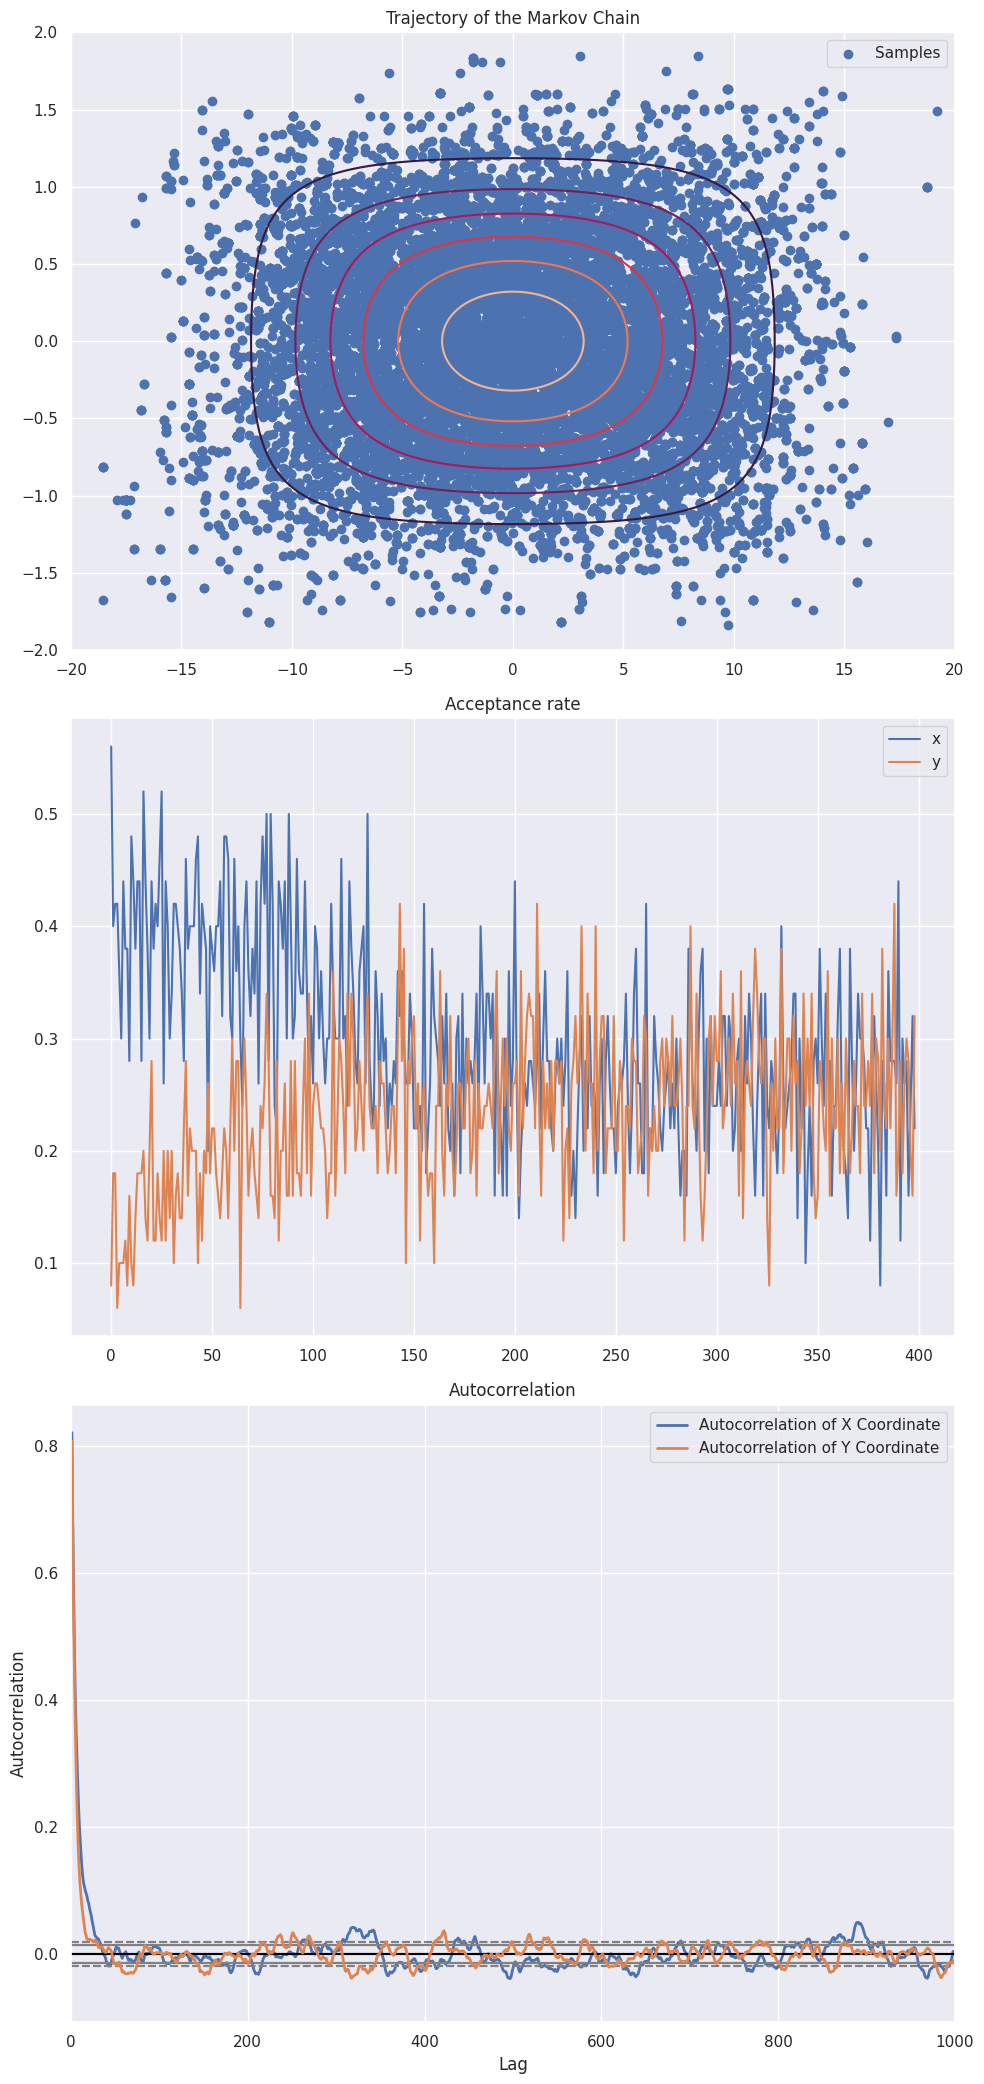

In [240]:
samples, acceptance_rate_history = adaptive_mcmc_hasting_metropolis([1, 1], 0.5, [3, 3], 10, 20000)
acceptance_x, acceptance_y = np.transpose(acceptance_rate_history)
plot_graphs(samples, acceptance_x, acceptance_y)

**Comments: We can see that the results are better with the adaptaion. The autocorrelation curves converge to 0 and are very close. We can also notive the fact that the acceptance rate is well near 0.24**

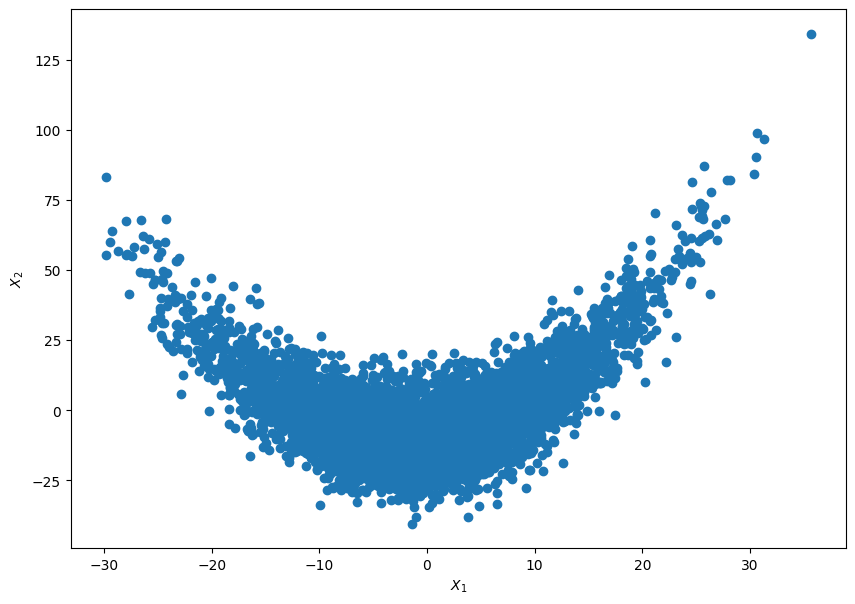

In [37]:
# Parameters 
d=20
B=0.1
sigma = np.array(pd.read_csv('tmalaexcov.txt' ,header=None , sep=' '))

# Create the data
data = np.random.multivariate_normal(mean=np.zeros(d),cov=sigma**2,size=5000)
data[:,1] = data[:,1] + B*(data[:,0]**2 - sigma[0,0]**2)

# Plots 
plt.figure(figsize=(10,7))
plt.scatter(data[:,0],data[:,1])
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

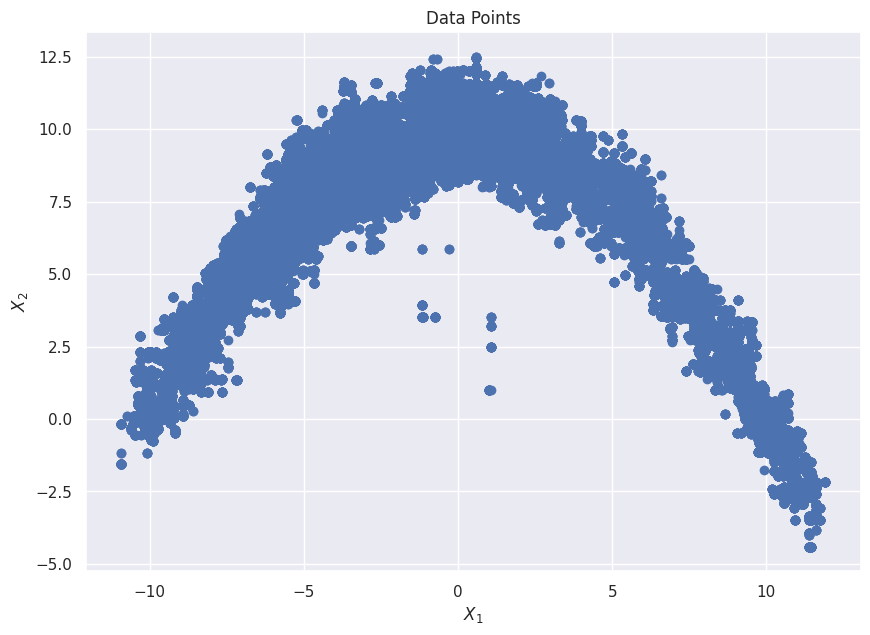

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

# Define the target distribution
def banana_dist(x, B):
    return np.exp(-x[0]**2/200 - 0.5*(x[1] + B*x[0]**2 - 100*B)**2 - 0.5*np.sum(x[2:]**2))

# Adaptive Metropolis-Hastings within Gibbs sampler
def adapt_MH_banana(x_init, B, dim, num_samples):
    samples = np.zeros((num_samples, dim))
    samples[0,:] = x_init
    acc_rate = np.zeros(dim)
    log_sigma = np.zeros(dim)
    batch_num = 0

    for i in range(1, num_samples):
        coord = np.random.randint(dim)        
        x = copy.deepcopy(samples[i-1,:])
        x[coord] = np.random.normal(samples[i-1,coord], np.exp(log_sigma[coord]))
        
        alpha = min(1, banana_dist(x, B) / banana_dist(samples[i-1,:], B))
        
        if np.random.rand() <= alpha:
            samples[i,:] = x
            acc_rate[coord] += 1
        else: 
            samples[i,:] = samples[i-1,:] 
            
        if i % 1000 == 0: 
            delta_j = min(0.01, 1/np.sqrt(batch_num+1)) 
            for k in range(dim): 
                if acc_rate[k] / 1000 > 0.24:
                    log_sigma[k] += delta_j    
                else: 
                    log_sigma[k] -= delta_j
            acc_rate = np.zeros(dim)
            batch_num += 1

    return samples

# Test the algorithm 
d = 20
B = 0.1
samples = adapt_MH_banana(np.ones(d), B, d, 100000)

# Plots 
plt.figure(figsize=(10,7))
plt.scatter(samples[:,0], samples[:,1])
plt.title('Data Points')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()


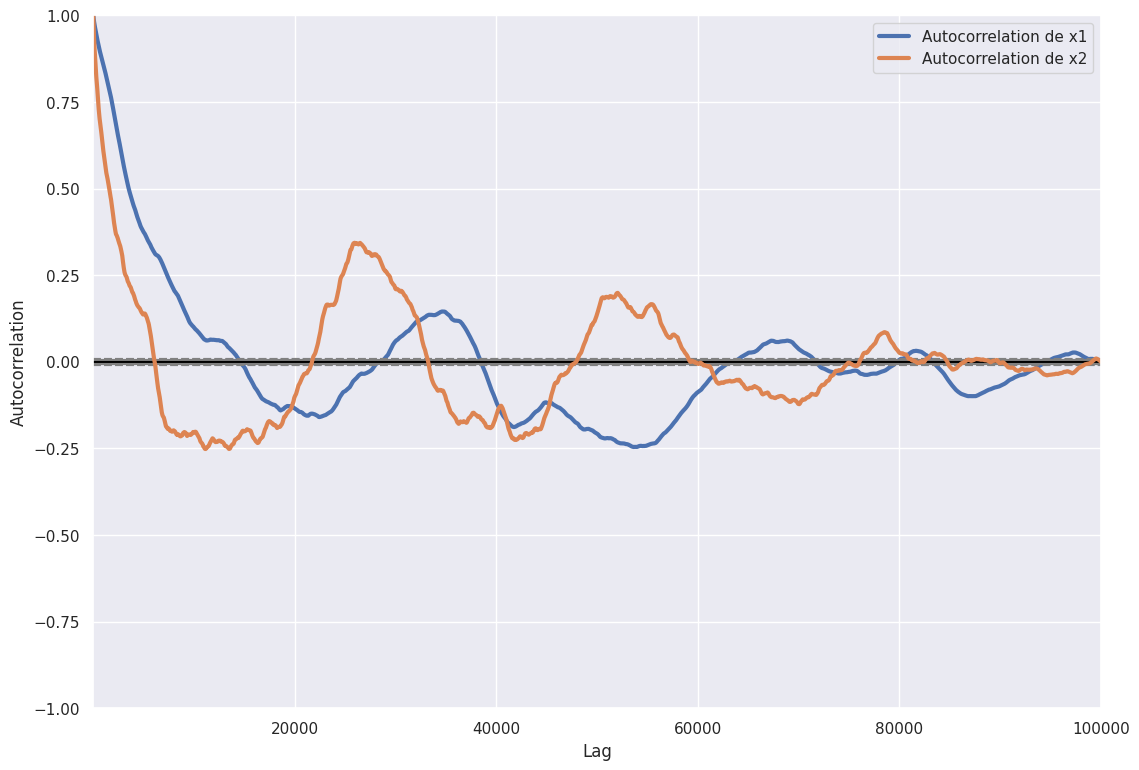

In [255]:
plt.figure(figsize=(13,9))
pd.plotting.autocorrelation_plot(samples[:,0], label='Autocorrelation de x1',linewidth=3)
pd.plotting.autocorrelation_plot(samples[:,1], label = 'Autocorrelation de x2',linewidth=3)

plt.show()

**Comments:** We can notice that we need a very high number of iterations for the algorithm to autocorrelation to converge towards 0, this can be explained by the complexity of the density. Also the fact that the data is not entirely random can explain it

## **Exercice 2: Sampling from multimodal distributions**
**Question1** <br>
Write a Metropolis-Hastings Symmetric Random Walk algorithm (you may use your code from
previous tutorial classes) to sample from $\pi$.

In [262]:
import numpy as np

# Define the target distribution
def pi(x, mu, sigma, w):
    return np.sum([w / (2 * np.pi * sd**2) * np.exp(-0.5 / sd**2 * np.dot(x - m, x - m)) for w, m, sd in zip(w, mu, sigma)])

# Metropolis-Hastings Symmetric Random Walk algorithm
def metropolis_hastings_symmetric_random_walk(target_distribution, proposal_distribution, start_state, num_samples):
    samples = np.zeros((num_samples, len(start_state)))
    samples[0] = start_state

    for i in range(1, num_samples):
        proposed_state = proposal_distribution(samples[i-1])
        acceptance_probability = min(1, target_distribution(proposed_state) / target_distribution(samples[i-1]))

        if np.random.rand() < acceptance_probability:
            samples[i] = proposed_state
        else:
            samples[i] = samples[i-1]

    return samples


mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],
               [3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],
               [6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],
               [4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.50],
               [1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])

sigma = np.full(20, 0.1)
w = np.full(20, 0.05)

# Run the algorithm
samples = metropolis_hastings_symmetric_random_walk(
    lambda x: pi(x, mu, sigma, w), 
    lambda x: np.random.normal(x, 1), 
    np.array([3,5]), 
    10000
)



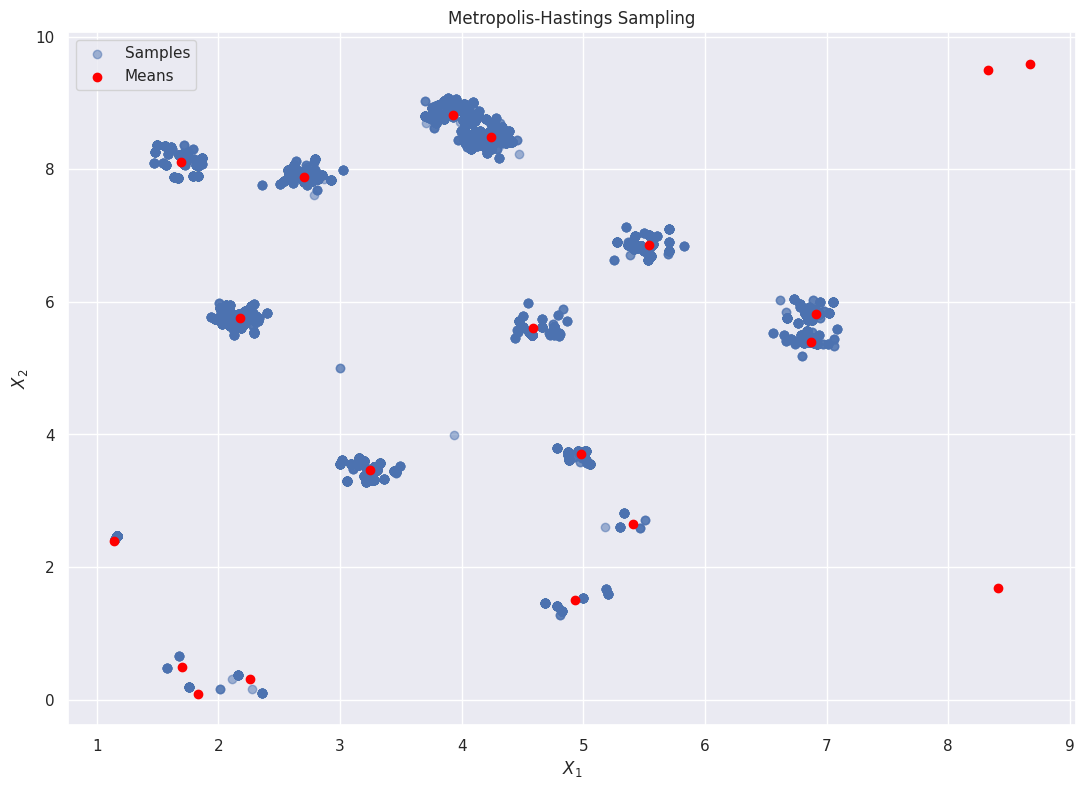

In [263]:
# Create the plot
plt.figure(figsize=(13,9))
plt.scatter(samples[:,0], samples[:,1], label='Samples', alpha=0.5)
plt.scatter(mu[:,0], mu[:,1], label='Means', color='red')
plt.legend()
plt.title('Metropolis-Hastings Sampling')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.show()

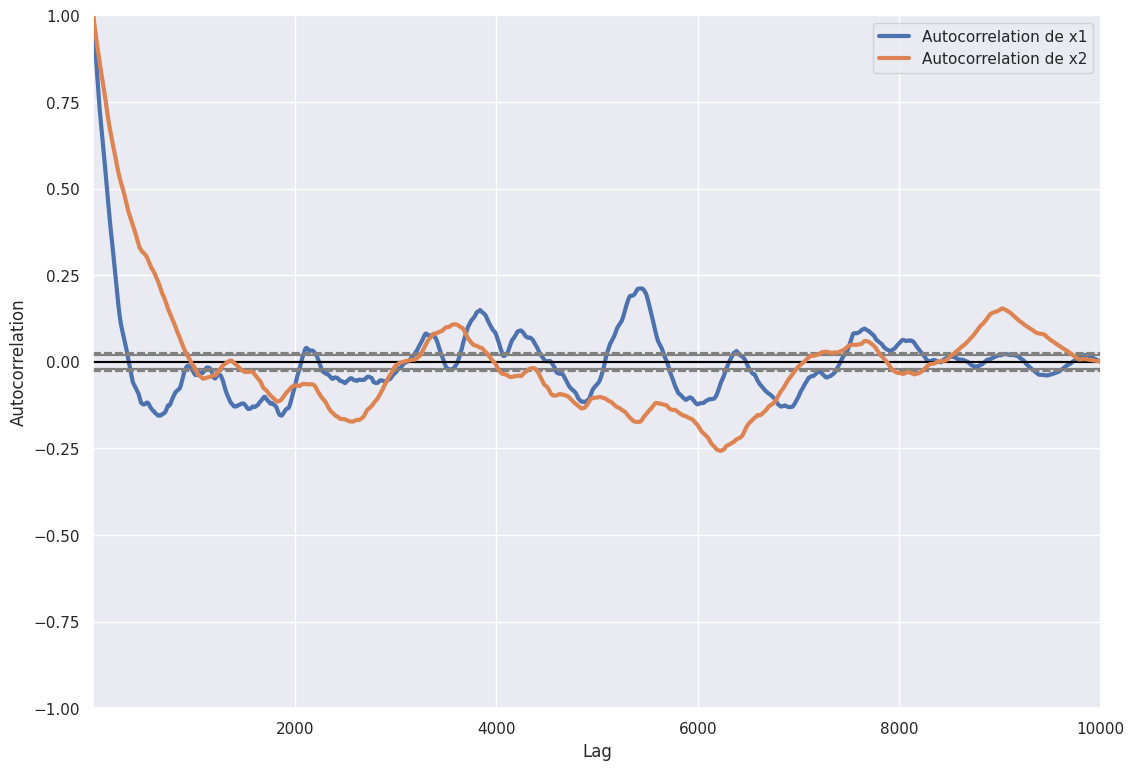

In [264]:
plt.figure(figsize=(13,9))
pd.plotting.autocorrelation_plot(samples[:,0], label='Autocorrelation de x1',linewidth=3)
pd.plotting.autocorrelation_plot(samples[:,1], label = 'Autocorrelation de x2',linewidth=3)

plt.show()

**Question 2**

In [265]:
def pi(x, mu, sigma, w):
    return np.sum([w / (2 * np.pi * sd**2) * np.exp(-0.5 / sd**2 * np.dot(x - m, x - m)) for w, m, sd in zip(w, mu, sigma)])

def adaptive_metropolis_hastings_multimodal(target_distribution, proposal_distribution, start_state, num_samples):
    samples = np.zeros((num_samples, len(start_state)))
    samples[0] = start_state
    acceptance_rate = 0
    log_sigma = 0

    for i in range(1, num_samples):
        proposed_state = proposal_distribution(samples[i-1], np.exp(log_sigma))
        acceptance_probability = min(1, target_distribution(proposed_state) / target_distribution(samples[i-1]))

        if np.random.rand() < acceptance_probability:
            samples[i] = proposed_state
            acceptance_rate += 1
        else:
            samples[i] = samples[i-1]

        if i % 50 == 0:
            if acceptance_rate / 50 > 0.24:
                log_sigma += min(0.01, i**(-0.5))
            else:
                log_sigma -= min(0.01, i**(-0.5))
            acceptance_rate = 0

    return samples

mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],
               [3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],
               [6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],
               [4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.50],
               [1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])

sigma = np.full(20, 0.1)
w = np.full(20, 0.05)

# Run the algorithm
samples = adaptive_metropolis_hastings_multimodal(
    lambda x: pi(x, mu, sigma, w), 
    lambda x, sigma: np.random.normal(x, sigma), 
    np.zeros(2), 
    10000
)


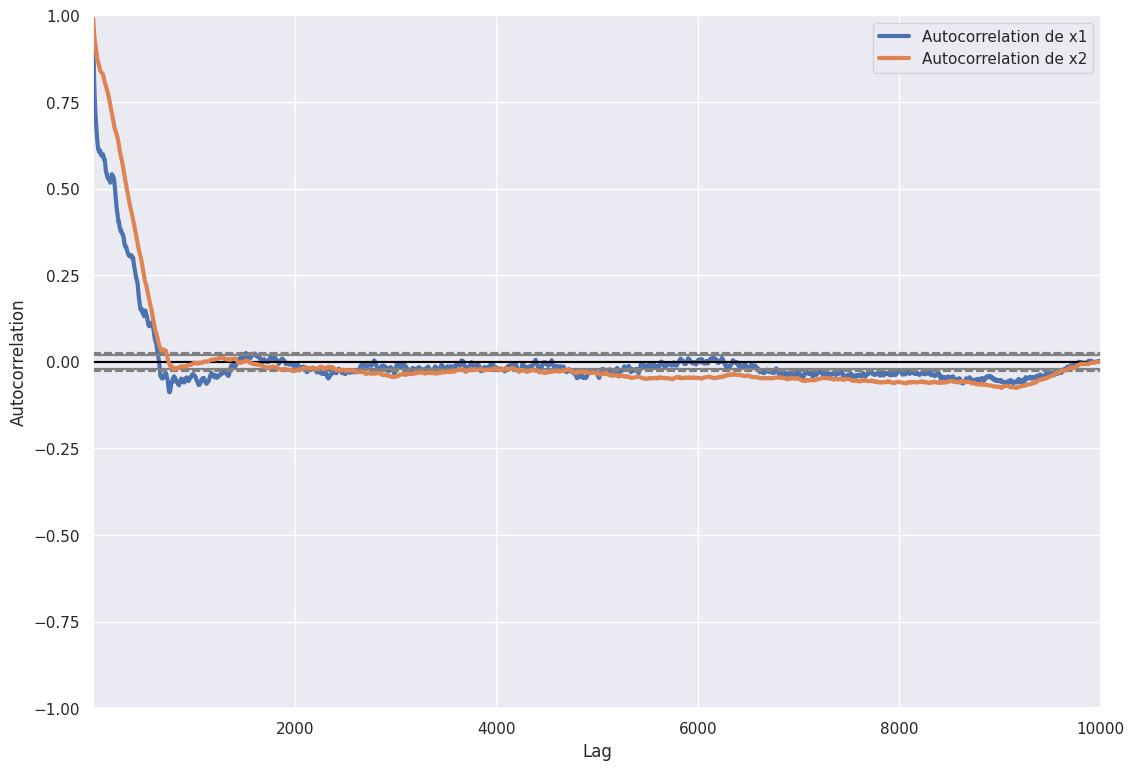

In [266]:
plt.figure(figsize=(13,9))
pd.plotting.autocorrelation_plot(samples[:,0], label='Autocorrelation de x1',linewidth=3)
pd.plotting.autocorrelation_plot(samples[:,1], label = 'Autocorrelation de x2',linewidth=3)

plt.show()

**Interpretation** <br>
The Metropolis-Hastings algorithm, including its adaptive version, can struggle with multimodal distributions. It often gets stuck in local modes and fails to explore the entire state space effectively. This is reflected in high autocorrelation and non-convergence of the autocorrelation to zero, indicating poor mixing and high dependence between consecutive samples

**2.B Parallel tempering**

In [278]:
import numpy as np

def pi(x: np.ndarray, weights: np.ndarray, means: np.ndarray, std_devs: np.ndarray, num_components: int) -> float: 
  sum_val = 0
  for i in range(num_components):
    sum_val += weights[i] / (2 * np.pi * std_devs[i]**2) * np.exp(-(x - means[i,:]).T.dot(x - means[i,:])/(2 * std_devs[i]**2))
  return sum_val

def parallel_tempering(temperatures: np.ndarray, num_iterations: int, weights: np.ndarray, means: np.ndarray, std_devs: np.ndarray, num_components: int = 20): 
  num_temps = len(temperatures)
  dim = 2
  samples = np.zeros((num_temps, num_iterations+1, dim))
  
  for n in range(num_iterations):
    
    for i in range(num_temps): 
      
      temp = temperatures[i]
      x = np.random.normal(samples[i,n,0], 0.25*np.sqrt(temp))
      X = np.array([x , samples[i,n,1]])
      
      alpha = min(1, (pi(X, weights, means, std_devs, num_components)/pi(samples[i,n,:], weights, means, std_devs, num_components))**(1 / temperatures[i]))
      U = np.random.rand()
      
      if U <= alpha: 
        samples[i,n+1,0] = x
      else: 
        samples[i,n+1,0] = samples[i,n,0] 
      y = np.random.normal(samples[i,n,1],0.25*np.sqrt(temp))
      Y = np.array([samples[i,n+1,0] , y])

      alpha = min(1, (pi(Y, weights, means, std_devs, num_components)/pi(samples[i,n,:], weights, means, std_devs, num_components))**(1 / temperatures[i]))
      U = np.random.rand()

      if U <= alpha: 
        samples[i,n+1,1] = y
      else:
        samples[i,n+1,1] = samples[i,n,1] 
    
    i = np.random.randint(0, num_temps) 
    j = np.random.randint(0, num_temps) 
    while np.abs(i-j) != 1:
      i = np.random.randint(0, num_temps) 
      j = np.random.randint(0, num_temps) 
        
    
    num = (pi(samples[j,n+1,:], weights, means, std_devs, num_components)**(1/temperatures[i])) * (pi(samples[i,n+1,:], weights, means, std_devs, num_components)**(1/temperatures[j]))
    den = (pi(samples[i,n+1,:], weights, means, std_devs, num_components)**(1/temperatures[i])) * (pi(samples[j,n+1,:], weights, means, std_devs, num_components)**(1/temperatures[j]))
    alpha_i_j = min(1, num / den)

    U = np.random.rand()
    if U <= alpha_i_j:
      samples[i,n+1,:], samples[j,n+1,:] = samples[j,n+1,:], samples[i,n+1,:]

  return samples


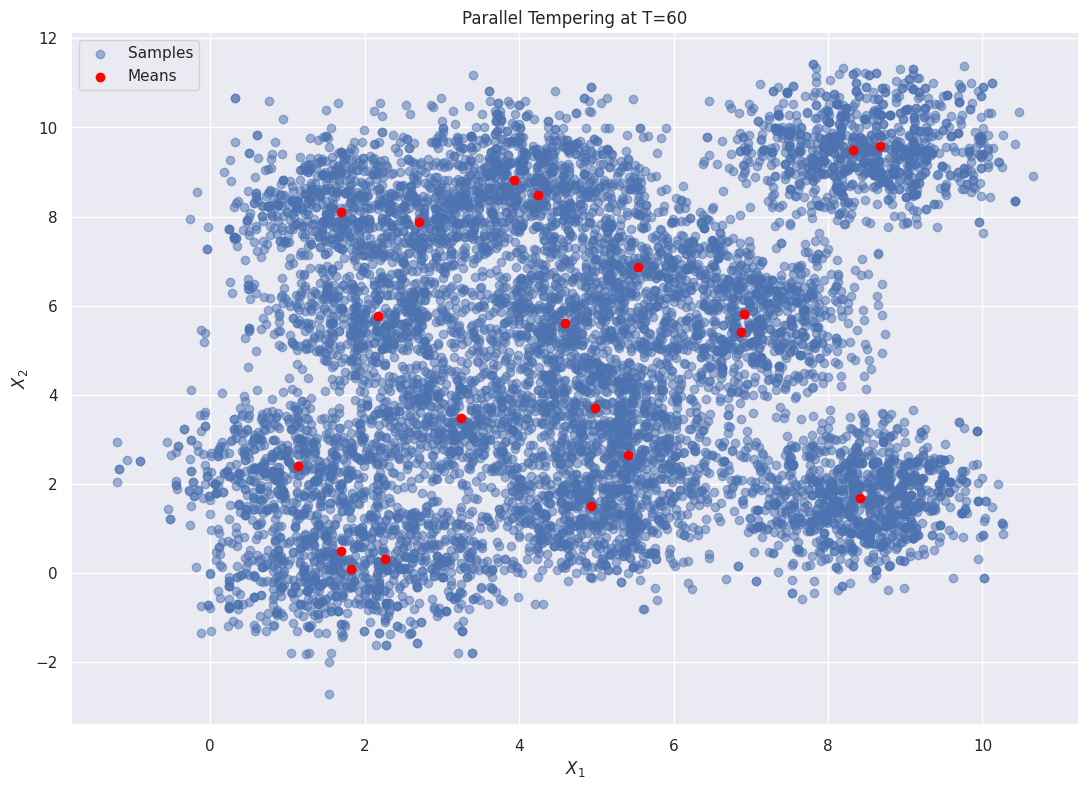

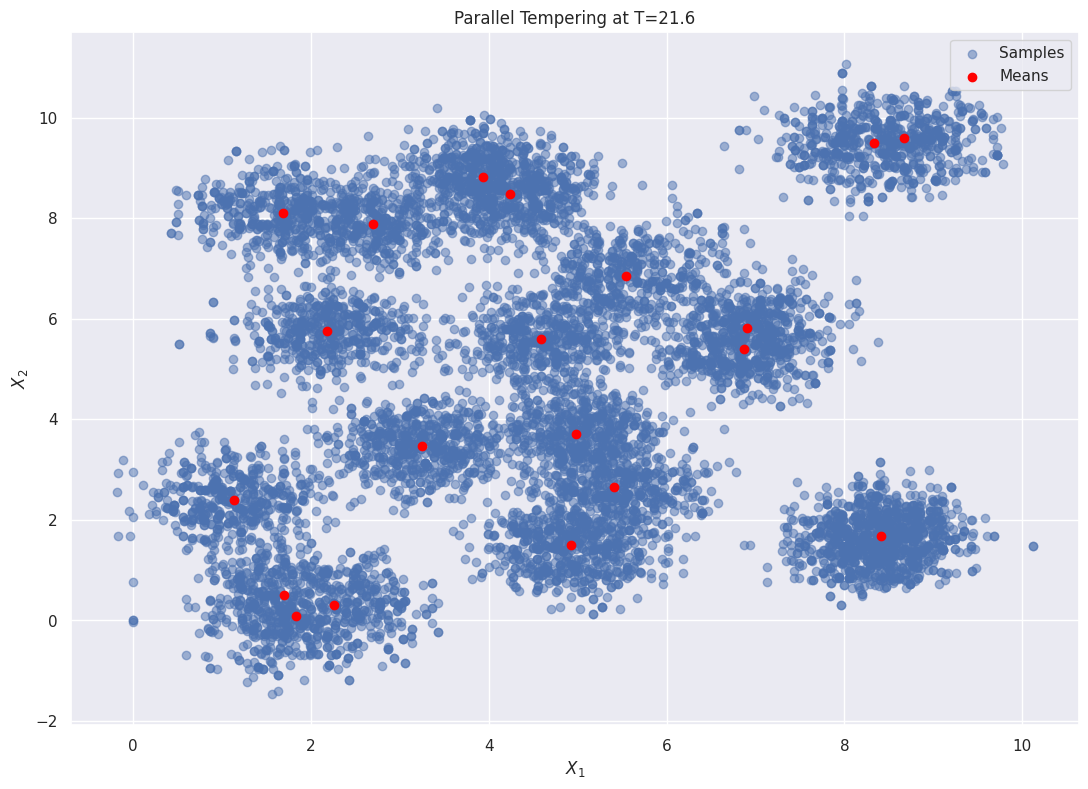

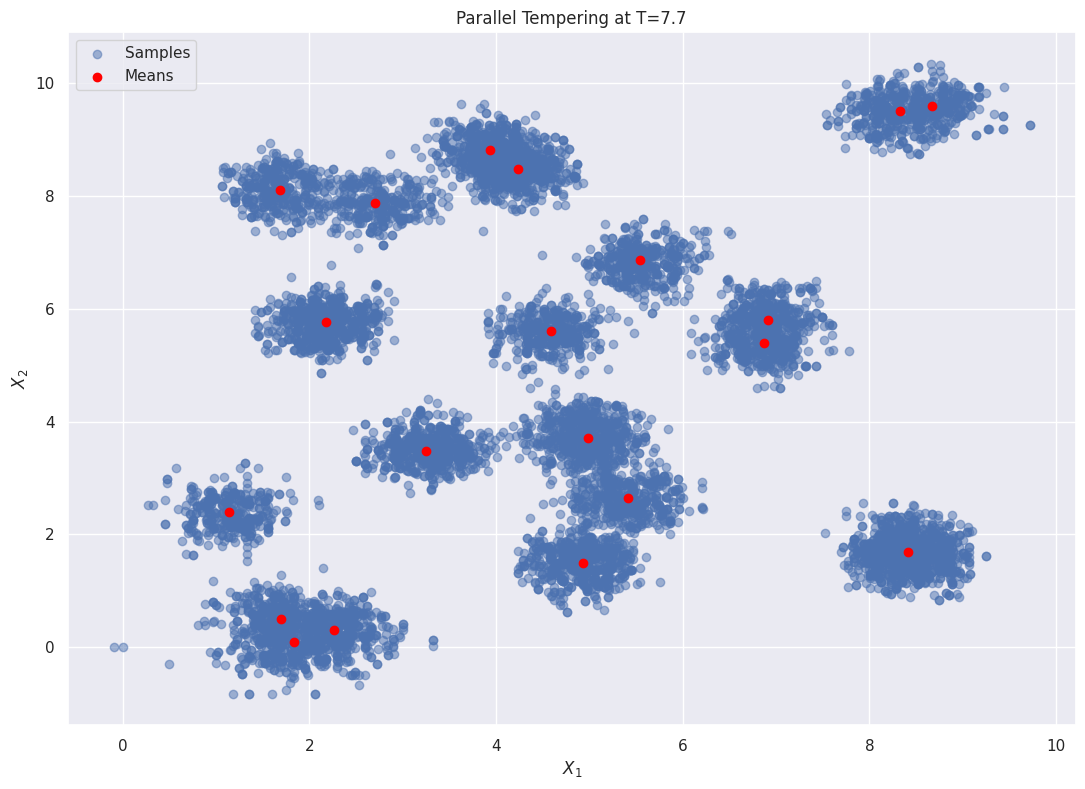

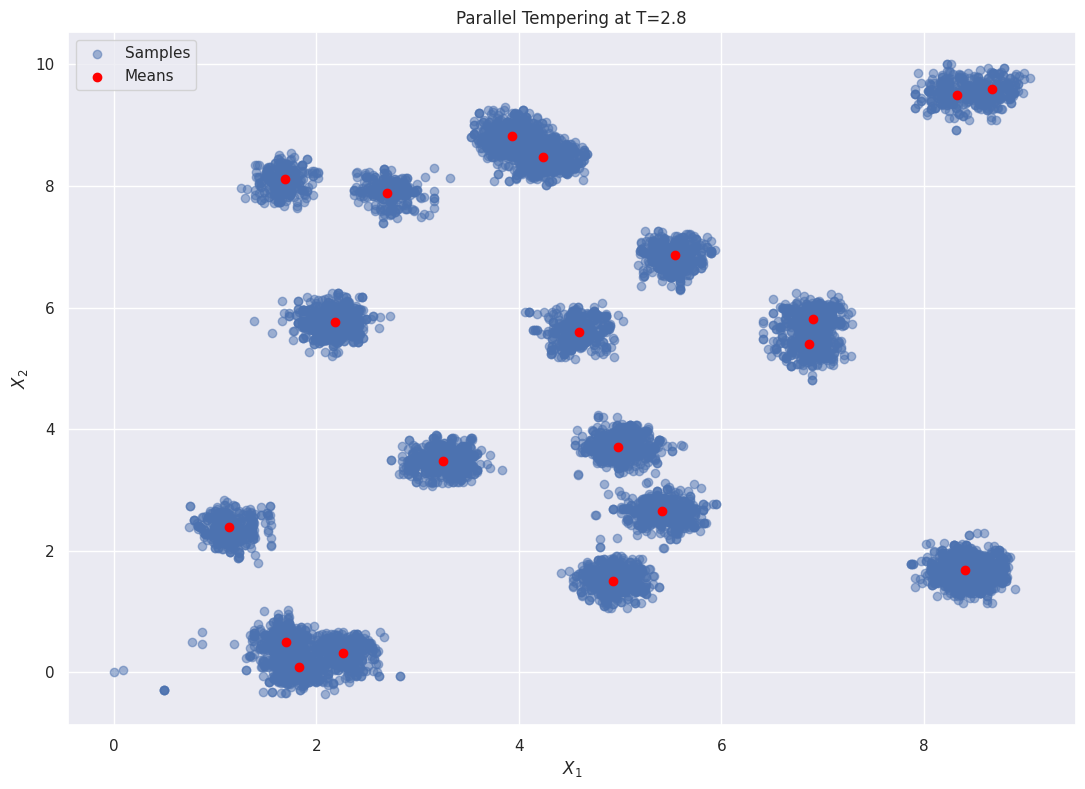

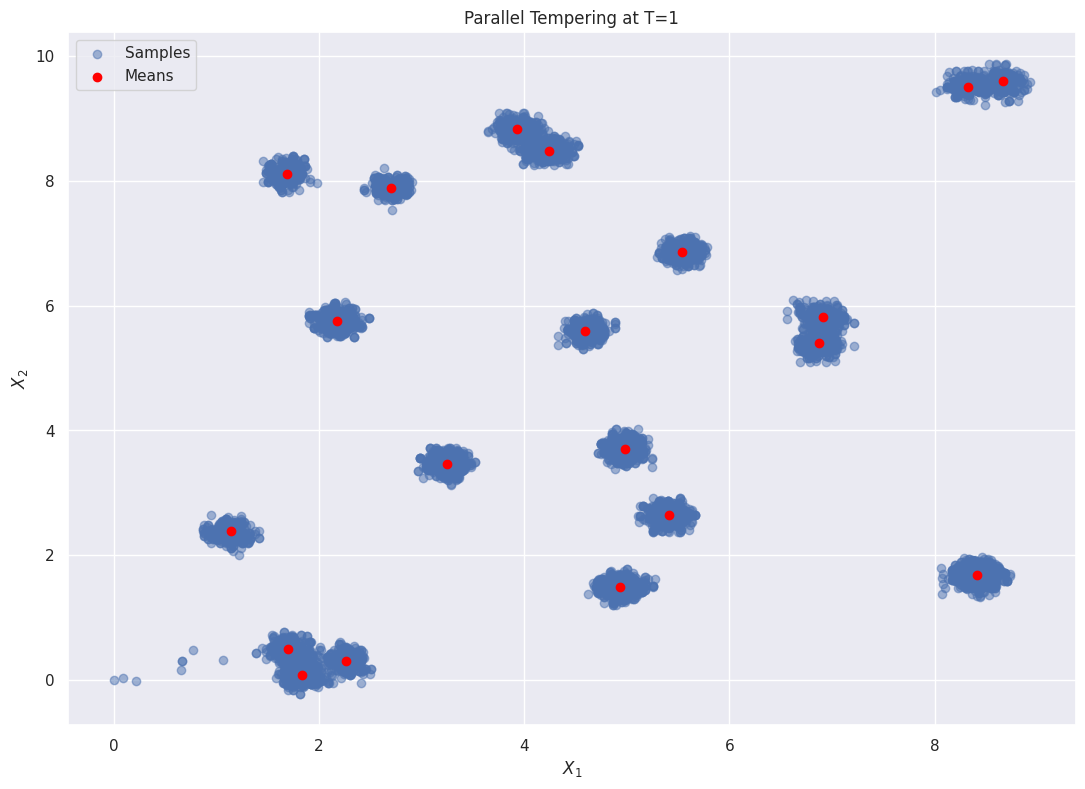

In [279]:
import matplotlib.pyplot as plt

T = [60, 21.6, 7.7, 2.8, 1]
num_comp = 20
N_iter = 10000
sigma = np.ones(num_comp) * 0.1
w = np.ones(num_comp) * 0.05
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],
               [3.93,8.82],[3.25,3.47],[1.70,0.50],[4.59,5.60],
               [6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],
               [4.98,3.70],[1.14,2.39],[8.33,9.50],[4.93,1.50],
               [1.83,0.09],[2.26,0.31],[5.54,6.86],[1.69,8.11]])

samples = parallel_tempering(T, N_iter, w, mu, sigma, num_components=num_comp)
for t in range(len(T)):

    # Create the plot
    plt.figure(figsize=(13,9))
    plt.scatter(samples[t,:,0], samples[t,:,1], label='Samples', alpha=0.5)
    plt.scatter(mu[:,0], mu[:,1], label='Means', color='red')
    plt.legend()
    plt.title(f'Parallel Tempering at T={T[t]}')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.grid(True)
    plt.show()


**Comments:** We can conclude that the parallel tempering is performing very well as it can sample accurately all the different modes.

# $\textbf{Exercise 3}$

**Question 1**, see the pdf

**Question 2** See the theoritical part on the pdf

In [280]:
import numpy as np
from scipy.stats import invgamma, norm, multivariate_normal

def gibbs_sampler(Y, X0, mu0, sigma0, tau0, alpha, beta, gamma, N, k, num_samples):
    X = X0
    mu = mu0
    sigma = sigma0
    tau = tau0

    mu_samples = []
    sigma_samples = []
    tau_samples = []
    X_samples = []

    for i in range(num_samples):
        X_new = np.zeros(N)
        mu_new = np.random.normal(np.mean(X), np.sqrt(sigma / N))
        sigma_new = invgamma.rvs(alpha + N/2, scale=beta + np.sum((X - mu)**2)/2)
        tau_new = invgamma.rvs(gamma + N*k/2, scale=beta + np.sum((Y.T - X)**2)/2)  

        for j in range(N): 
            mean = (tau * mu + sigma * np.sum(Y[j,:])) / (k * sigma + tau)
            var = np.sqrt((sigma * tau) / (k * sigma + tau))
            X_new[j] = np.random.normal(loc=mean, scale=var) 

        X = X_new
        mu = mu_new
        sigma = sigma_new
        tau = tau_new

        mu_samples.append(mu_new)
        sigma_samples.append(sigma_new)
        tau_samples.append(tau_new)
        X_samples.append(X_new)

    return mu_samples, sigma_samples, tau_samples, X_samples


In [285]:
from scipy.stats import invgamma

def block_gibbs_sampler(Y, X0, mu0, sigma0, tau0, alpha, beta, gamma, N, k, N_iter):
    # Initialize variables
    X = X0
    mu = mu0
    sigma = sigma0
    tau = tau0

    # Store the samples
    mu_samples = []
    sigma_samples = []
    tau_samples = []
    X_samples = []

    Y_ = np.zeros(N+1)
    Y_[:N] = np.sum(Y, axis=1)

    for i in range(N_iter):
        # Update sigma
        a_new = N/2 + alpha
        b_new = np.sum((X - mu)**2)/2 + beta
        sigma_new = 1 / np.random.gamma(shape=a_new, scale=1/b_new)

        # Update tau
        a_new = N*k/2 + gamma
        b_new = np.sum((Y.T - X)**2)/2 + beta
        tau_new = 1 / np.random.gamma(shape=a_new, scale=1/b_new)

        # Update the block (X, mu)
        precision = np.zeros((N+1,N+1))
        for j in range(N):
            precision[j,j] = (k*sigma_new + tau_new)/(sigma_new * tau_new)
        precision[:,N] = -1 / sigma_new
        precision[N,:] = -1 / sigma_new
        precision[N,N] = N / sigma_new

        cov = np.linalg.pinv(precision)
        mean = np.dot(cov , Y_ / tau_new)

        mvg = np.random.multivariate_normal(mean=mean, cov=cov, size=1).reshape(N+1)
        X_new = mvg[:N]
        mu_new = mvg[N]

        # Store the samples
        mu_samples.append(mu_new)
        sigma_samples.append(sigma_new)
        tau_samples.append(tau_new)
        X_samples.append(X_new)

        # Update the parameters for the next iteration
        X = X_new
        mu = mu_new
        sigma = sigma_new
        tau = tau_new

    return mu_samples, sigma_samples, tau_samples, X_samples


- Gibbs Sampler: This method updates one variable at a time given the current values of the other variables. While easy to implement, its performance can suffer when dealing with high-dimensional problems or when variables are highly correlated, leading to slow mixing and convergence.

- Block-Gibbs Sampler: This method updates a subset (or ‘block’) of variables jointly at each step. If the variables within a block are highly correlated, updating them together can lead to faster mixing and convergence. However, determining the optimal blocking structure can be challenging, and the computational cost of sampling a block of variables jointly can be higher than sampling each variable individually.

In summary: Block-Gibbs samplers can potentially converge faster and reduce autocorrelation by updating highly correlated parameters together. However, if block updates require computationally expensive operations, such as inverting a large matrix, Block-Gibbs samplers may be less efficient than standard Gibbs samplers.

In [286]:
import numpy as np
from scipy.stats import norm, invgamma

# Set the true parameters
N = 200  # number of groups
k = 40 # number of observations per group
mu_true = 0  # true mean

# Sample sigma^2 and tau^2 from Inverse-Gamma distributions
alpha, beta = 2, 2  # hyperparameters for Inverse-Gamma
sigma2_true = invgamma.rvs(a=alpha, scale=beta)
tau2_true = invgamma.rvs(a=alpha, scale=beta)

# Generate the synthetic dataset
X_true = np.random.normal(mu_true, np.sqrt(sigma2_true), N)
Y = np.array([np.random.normal(X_true[i], np.sqrt(tau2_true), k) for i in range(N)])

# Set the initial values and hyperparameters for the samplers
X0 = np.zeros(N)
mu0 = 0
sigma0 = 1
tau0 = 1
alpha = 0.1
beta = 0.1
gamma = 0.1
N_iter = 10000

gibbs_samples = gibbs_sampler(Y, X0, mu0, sigma0, tau0, alpha, beta, gamma, N, k, N_iter)
block_gibbs_samples = block_gibbs_sampler(Y, X0, mu0, sigma0, tau0, alpha, beta, gamma, N, k, N_iter)



In [287]:
# Assume 'gibbs_samples' and 'block_gibbs_samples' are the outputs from your Gibbs sampler and Block-Gibbs sampler functions
mu_samples_gibbs, sigma2_samples_gibbs, tau2_samples_gibbs, X_samples_gibbs = gibbs_samples
mu_samples_block, sigma2_samples_block, tau2_samples_block, X_samples_block = block_gibbs_samples

# Compute the means
mu_mean_gibbs = np.mean(mu_samples_gibbs)
sigma2_mean_gibbs = np.mean(sigma2_samples_gibbs)
tau2_mean_gibbs = np.mean(tau2_samples_gibbs)
X_mean_gibbs = np.mean(X_samples_gibbs, axis=0)  # mean of X for each group

mu_mean_block = np.mean(mu_samples_block)
sigma2_mean_block = np.mean(sigma2_samples_block)
tau2_mean_block = np.mean(tau2_samples_block)
X_mean_block = np.mean(X_samples_block, axis=0)  # mean of X for each group

print('Gibbs sampler:')
print(f'Mean of mu: {mu_mean_gibbs}, true value: {mu_true}')
print(f'Mean of sigma2: {sigma2_mean_gibbs}, true value: {sigma2_true}')
print(f'Mean of tau2: {tau2_mean_gibbs}, true value: {tau2_true}')

print('\nBlock-Gibbs sampler:')
print(f'Mean of mu: {mu_mean_block}, true value: {mu_true}')
print(f'Mean of sigma2: {sigma2_mean_block}, true value: {sigma2_true}')
print(f'Mean of tau2: {tau2_mean_block}, true value: {tau2_true}')

Gibbs sampler:
Mean of mu: -0.09880047874807651, true value: 0
Mean of sigma2: 1.406877773233729, true value: 1.3087978024340325
Mean of tau2: 1.5518844382852703, true value: 1.527998697328591

Block-Gibbs sampler:
Mean of mu: -0.09791464272642142, true value: 0
Mean of sigma2: 1.406248796215089, true value: 1.3087978024340325
Mean of tau2: 1.5521452840430385, true value: 1.527998697328591


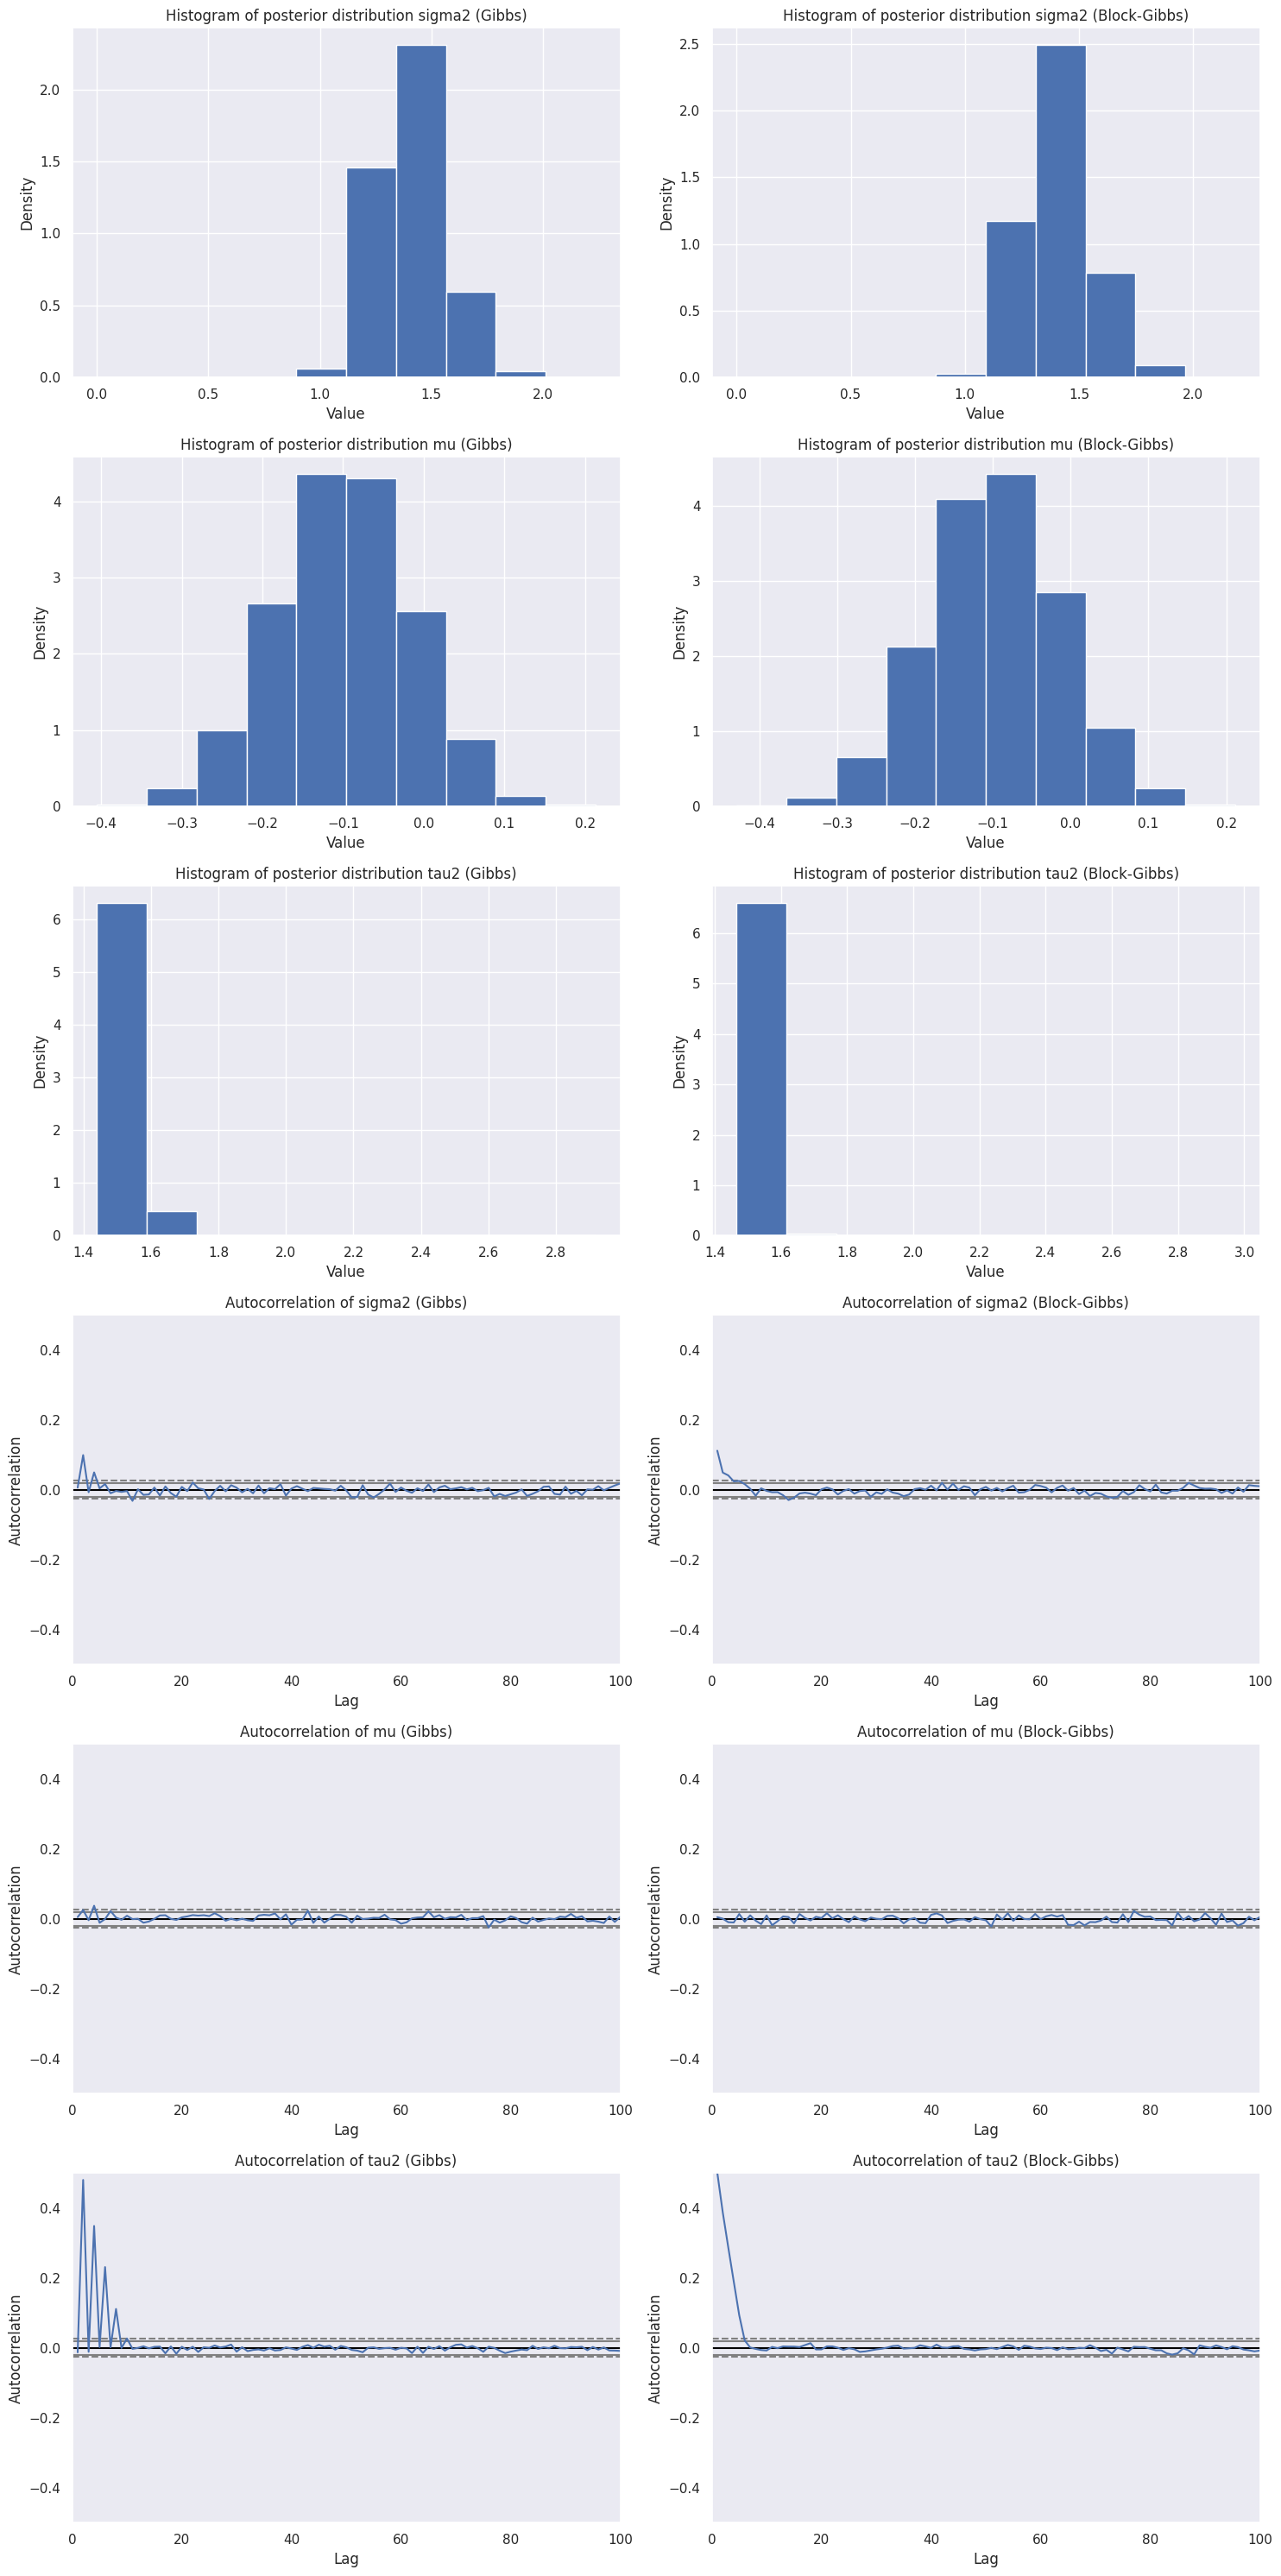

In [288]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a new figure
fig, axs = plt.subplots(6, 2, figsize=(15, 30))

# Histograms for Gibbs sampler
axs[0, 0].hist(sigma2_samples_gibbs, density=True)
axs[0, 0].set_title('Histogram of posterior distribution sigma2 (Gibbs)')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Density')

axs[1, 0].hist(mu_samples_gibbs, density=True)
axs[1, 0].set_title('Histogram of posterior distribution mu (Gibbs)')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Density')

axs[2, 0].hist(tau2_samples_gibbs, density=True)
axs[2, 0].set_title('Histogram of posterior distribution tau2 (Gibbs)')
axs[2, 0].set_xlabel('Value')
axs[2, 0].set_ylabel('Density')

# Histograms for Block-Gibbs sampler
axs[0, 1].hist(sigma2_samples_block, density=True)
axs[0, 1].set_title('Histogram of posterior distribution sigma2 (Block-Gibbs)')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Density')

axs[1, 1].hist(mu_samples_block, density=True)
axs[1, 1].set_title('Histogram of posterior distribution mu (Block-Gibbs)')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Density')

axs[2, 1].hist(tau2_samples_block, density=True)
axs[2, 1].set_title('Histogram of posterior distribution tau2 (Block-Gibbs)')
axs[2, 1].set_xlabel('Value')
axs[2, 1].set_ylabel('Density')

# Autocorrelation plots for Gibbs sampler
pd.plotting.autocorrelation_plot(pd.DataFrame(sigma2_samples_gibbs, columns=["Values"]), ax=axs[3, 0])
axs[3, 0].set_title('Autocorrelation of sigma2 (Gibbs)')
axs[3, 0].set_xlabel('Lag')
axs[3, 0].set_ylim((-.5,.5)) 
axs[3, 0].set_xlim((0,100))

pd.plotting.autocorrelation_plot(pd.DataFrame(mu_samples_gibbs, columns=["Values"]), ax=axs[4, 0])
axs[4, 0].set_title('Autocorrelation of mu (Gibbs)')
axs[4, 0].set_xlabel('Lag')
axs[4, 0].set_ylim((-.5,.5)) 
axs[4, 0].set_xlim((0,100))

pd.plotting.autocorrelation_plot(pd.DataFrame(tau2_samples_gibbs, columns=["Values"]), ax=axs[5, 0])
axs[5, 0].set_title('Autocorrelation of tau2 (Gibbs)')
axs[5, 0].set_xlabel('Lag')
axs[5, 0].set_ylim((-.5,.5)) 
axs[5, 0].set_xlim((0,100))

# Autocorrelation plots for Block-Gibbs sampler
pd.plotting.autocorrelation_plot(pd.DataFrame(sigma2_samples_block, columns=["Values"]), ax=axs[3, 1])
axs[3, 1].set_title('Autocorrelation of sigma2 (Block-Gibbs)')
axs[3, 1].set_xlabel('Lag')
axs[3, 1].set_ylim((-.5,.5)) 
axs[3, 1].set_xlim((0,100))

pd.plotting.autocorrelation_plot(pd.DataFrame(mu_samples_block, columns=["Values"]), ax=axs[4, 1])
axs[4, 1].set_title('Autocorrelation of mu (Block-Gibbs)')
axs[4, 1].set_xlabel('Lag')
axs[4, 1].set_ylim((-.5,.5)) 
axs[4, 1].set_xlim((0,100))

pd.plotting.autocorrelation_plot(pd.DataFrame(tau2_samples_block, columns=["Values"]), ax=axs[5, 1])
axs[5, 1].set_title('Autocorrelation of tau2 (Block-Gibbs)')
axs[5, 1].set_xlabel('Lag')
axs[5, 1].set_ylim((-.5,.5)) 
axs[5, 1].set_xlim((0,100))

plt.tight_layout()
plt.show()


Comments: Consistent with the theoritical results, even here from the histograms, both methods seems to give the same results.